In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------------- Constants and ODE ------------------------
GMsun = 1.3271244e20
c = 299792458.0
tsun = GMsun / (c**3)
yr = 365.25 * 24 * 3600

def odes(t, z, M, eta):
    n, e = z
    Mc = M * eta**(3/5)
    OTS = np.sqrt(1 - e**2)
    dndt = 1/5 * (Mc*tsun*n)**(5/3) * n**2 * ((96 + 292*e**2 + 37*e**4)/OTS**7)
    dedt = -1/15 * (Mc*tsun*n)**(5/3) * n * e * ((304 + 121*e**2)/OTS**5)
    return [dndt, dedt]

def solve_rr_ivp(M, eta, z0, Tarr):
    sol = solve_ivp(odes, [Tarr[0], Tarr[-1]], z0, args=(M, eta),
                    t_eval=Tarr, rtol=1e-10, atol=1e-10)
    return sol.y[0], sol.y[1]

# ---------------------- Generate training data -------------------
M, eta = 1e9, 0.25
z0 = [1e-7, 0.8]
Tarr = np.linspace(0, 12, 500) * yr
n_true, e_true = solve_rr_ivp(M, eta, z0, Tarr)

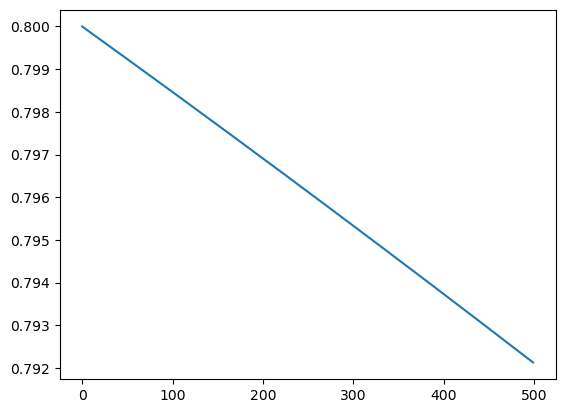

In [7]:
plt.plot(e_true)

In [8]:
print(f"Using device: {device}")

Using device: mps


In [9]:
# ---------------------- Convert to torch -------------------------
device = "mps" if torch.backends.mps.is_available() else \
         "cuda" if torch.cuda.is_available() else "cpu"

t = torch.tensor(Tarr, dtype=torch.float32).view(-1,1).to(device)
n = torch.tensor(n_true, dtype=torch.float32).view(-1,1).to(device)
e = torch.tensor(e_true, dtype=torch.float32).view(-1,1).to(device)

# ---------------------- Manual scaling (mean/std) ----------------
t_mean, t_std = t.mean(), t.std()
n_mean, n_std = n.mean(), n.std()
e_mean, e_std = e.mean(), e.std()

t_s = (t - t_mean) / t_std
n_s = (n - n_mean) / n_std
e_s = (e - e_mean) / e_std
t_s.requires_grad_(True)

# ---------------------- Simple MLP -------------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

# ---------------------- Train loop -------------------------------
for epoch in range(2000):
    opt.zero_grad()

    out = model(t_s)
    n_hat_s, e_hat_s = out[:,0:1], out[:,1:2]

    # Unscale to physical values
    n_hat = n_hat_s * n_std + n_mean
    e_hat = e_hat_s * e_std + e_mean

    # Derivatives (scaled)
    dn_s_dt_s = torch.autograd.grad(n_hat_s, t_s, torch.ones_like(n_hat_s),
                                    create_graph=True)[0]
    de_s_dt_s = torch.autograd.grad(e_hat_s, t_s, torch.ones_like(e_hat_s),
                                    create_graph=True)[0]

    # Chain rule back to physical space
    dn_dt = (n_std / t_std) * dn_s_dt_s
    de_dt = (e_std / t_std) * de_s_dt_s

    # Physics RHS
    Mc = M * eta**(3/5)
    OTS = torch.sqrt(1 - e_hat**2 + 1e-10)
    dndt_true = 1/5 * (Mc*tsun*n_hat)**(5/3) * n_hat**2 * ((96+292*e_hat**2+37*e_hat**4)/OTS**7)
    dedt_true = -1/15 * (Mc*tsun*n_hat)**(5/3) * n_hat * e_hat * ((304+121*e_hat**2)/OTS**5)

    physics_loss = torch.mean((dn_dt - dndt_true)**2 + (de_dt - dedt_true)**2)
    data_loss = torch.mean((n_hat_s - n_s)**2 + (e_hat_s - e_s)**2)
    loss = physics_loss + data_loss

    loss.backward()
    opt.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Total: {loss.item():.2e} | Phys: {physics_loss.item():.2e}")

Epoch    0 | Total: 2.70e+00 | Phys: 4.54e-22
Epoch  200 | Total: 4.27e-04 | Phys: 4.47e-24
Epoch  400 | Total: 2.11e-04 | Phys: 2.19e-24
Epoch  600 | Total: 1.14e-04 | Phys: 1.31e-24
Epoch  800 | Total: 5.87e-05 | Phys: 7.81e-25
Epoch 1000 | Total: 2.81e-05 | Phys: 4.63e-25
Epoch 1200 | Total: 1.28e-05 | Phys: 2.81e-25
Epoch 1400 | Total: 6.42e-06 | Phys: 1.82e-25
Epoch 1600 | Total: 4.04e-06 | Phys: 1.29e-25
Epoch 1800 | Total: 3.09e-06 | Phys: 9.83e-26


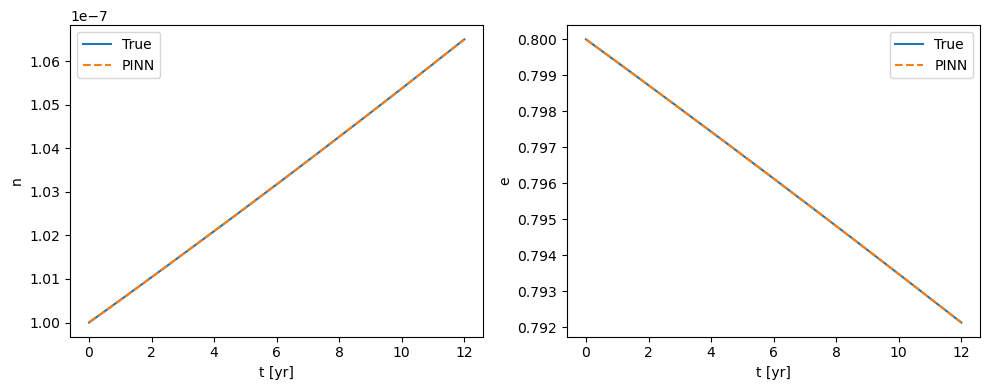

In [10]:
# ---------------------- Predict & plot ----------------------------
with torch.no_grad():
    out = model(t_s)
    n_pred = (out[:,0:1] * n_std + n_mean).cpu().numpy()
    e_pred = (out[:,1:2] * e_std + e_mean).cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Tarr/yr, n_true, label="True")
plt.plot(Tarr/yr, n_pred, "--", label="PINN")
plt.xlabel("t [yr]"); plt.ylabel("n"); plt.legend()

plt.subplot(1,2,2)
plt.plot(Tarr/yr, e_true, label="True")
plt.plot(Tarr/yr, e_pred, "--", label="PINN")
plt.xlabel("t [yr]"); plt.ylabel("e"); plt.legend()

plt.tight_layout()
plt.show()